In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from aif360.metrics import ClassificationMetric
from aif360.algorithms.inprocessing import AdversarialDebiasing
from aif360.datasets import BinaryLabelDataset
import tensorflow as tf
import random

/Users/elnararb/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/elnararb/Library/Python/3.9/lib/python/site-packages/inFairness/utils/ndcg.py:37: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  vect_normalized_discounted_cumulative_gain = vmap(
/Users/elnararb/Library/Python/3.9/lib/python/site-packages/inFairness/utils/ndcg.py:48: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is depr

In [2]:
 # Ensure TensorFlow compatibility with AIF360
tf.compat.v1.disable_eager_execution()

Path Configuration

In [3]:
CURRENT_DIR = os.getcwd()
DATA_FILE = os.path.join(CURRENT_DIR, 'adult.csv')

Updated data types based on the actual data format

In [4]:
data_types = {
    "age": np.float64,
    "workclass": "category",
    "fnlwgt": np.float64,
    "education": "category",
    "educational-num": np.float64,
    "marital-status": "category",
    "occupation": "category",
    "relationship": "category",
    "race": "category",
    "gender": "category",
    "capital-gain": np.float64,
    "capital-loss": np.float64,
    "hours-per-week": np.float64,
    "native-country": "category",
    "income": "category"
}

In [17]:
def read_dataset():
    """
    Read the adult.csv dataset with appropriate data types and handling
    """
    print(f"Reading data from: {DATA_FILE}")
    if not os.path.exists(DATA_FILE):
        raise FileNotFoundError(f"Data file not found at: {DATA_FILE}")
    
    df = pd.read_csv(
        DATA_FILE,
        dtype=data_types,
        na_values=['?'],
    )
    
    # Rename columns to standardized format
    df = df.rename(columns={
        'educational-num': 'education_num',
        'marital-status': 'marital_status',
        'capital-gain': 'capital_gain',
        'capital-loss': 'capital_loss',
        'hours-per-week': 'hours_per_week',
        'native-country': 'native_country',
        'gender': 'sex'  # Rename gender to sex for consistency
    })
    
    print("\nDataset shape:", df.shape)
    print("\nColumns after renaming:", df.columns.tolist())
    print("\nMissing values:\n", df.isnull().sum())
    
    return df

In [18]:
def clean_dataset(data):
    """
    Clean the dataset by handling missing values and preparing target variable
    """
    # Make a copy to avoid modifying the original data
    data = data.copy()
    
    # Remove fnlwgt column
    if 'fnlwgt' in data.columns:
        data = data.drop('fnlwgt', axis=1)
    
    # Remove duplicates
    data = data.drop_duplicates()
    
    # Binarize target variable (>50K == 1 and <=50K == 0)
    data['income'] = data['income'].apply(lambda x: 1 if '>50K' in str(x) else 0)
    data = data.rename(columns={'income': 'income_class'})
    
    # Fill missing values
    categorical_columns = data.select_dtypes(include=['category']).columns
    numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
    
    # Fill missing values for categorical columns with mode
    for col in categorical_columns:
        data[col] = data[col].fillna(data[col].mode()[0])
    
    # Fill missing values for numerical columns with median
    for col in numerical_columns:
        data[col] = data[col].fillna(data[col].median())
    
    return data

In [ ]:
class AdultClassificationPipeline:
    def __init__(self, full_data):
        """
        Initialize classification pipeline
        Args:
            full_data: Complete dataset
        """
        self.full_data = full_data
        self.model = None
        self.scaler = StandardScaler()
        self.feature_names = full_data.loc[:, full_data.columns != 'income_class'].columns.tolist()
        
    def preprocess_features(self, df):
        """
        Basic feature preprocessing pipeline as required by the project:
        - Basic numerical feature standardization
        - Basic categorical feature encoding
        """
        df = df.copy()
        
        # 1. Binarize age feature (available for other project parts)
        age_median = df['age'].median()
        df['age_binary'] = (df['age'] > age_median).astype(int)
        df = df.drop('age', axis=1) # Remove original age column
        
        # 2. Feature splitting
        numeric_features = ['education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
        categorical_features = ['workclass', 'education', 'marital_status', 'occupation',
                            'relationship', 'race', 'sex', 'native_country']
        
        # 3. Standardization of numerical features
        df[numeric_features] = self.scaler.fit_transform(df[numeric_features])
        
        # 4. Categorical encoding
        df_categorical = pd.get_dummies(df[categorical_features])
        df_categorical=df_categorical.drop(columns='sex_Female')
        
        # 5. Combine features
        features = pd.concat([
            df[numeric_features],
            df_categorical,
            df[['age_binary']]
        ], axis=1)
        
        self.feature_names = features.columns.tolist()
        return features
    
    def prepare_data(self):
            """
            Prepare and split data after preprocessing
            """
            # First preprocess all data
            X_full = self.preprocess_features(self.full_data)
            y_full = self.full_data['income_class']
            processed_dataset=pd.concat([X_full, y_full], axis=1)

            # Now split into train/val/test
            # First split: separate test set
            X_temp, X_test, y_temp, y_test = train_test_split(
                X_full, y_full, 
                test_size=0.2,
                random_state=42,
                stratify=y_full
            )

            # Second split: create validation set
            X_train, X_val, y_train, y_val = train_test_split(
                X_temp, y_temp,
                test_size=0.25,
                random_state=42,
                stratify=y_temp
            )
            
            print("\nData split sizes:")
            print(f"Training set: {X_train.shape[0]} samples")
            print(f"Validation set: {X_val.shape[0]} samples")
            print(f"Test set: {X_test.shape[0]} samples")
            
            return processed_dataset, X_train, X_val, X_test, y_train, y_val, y_test
    
    def train_model(self, X_train, X_val, y_train, y_val):
        """
        Train LightGBM model with validation-based early stopping
        """
        print("\nTraining LightGBM model...")
        
        # Define model with balanced class weights
        self.model = lgb.LGBMClassifier(
            n_estimators=1000,
            learning_rate=0.05,
            num_leaves=32,
            max_depth=6,
            class_weight='balanced',
            random_state=42
        )
        
        # Train with early stopping
        self.model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric='auc',
            callbacks=[
                early_stopping(stopping_rounds=50),
                log_evaluation(period=100)
            ]
        )
        
        return self.model
    
    def evaluate_model(self, X, y, dataset_name=""):
        """
        Evaluate model performance
        """
        predictions = self.model.predict(X)
        self.evaluate_performance(y,predictions,dataset_name)
        
        # Plot feature importance
        if dataset_name == "Test":
            self.plot_feature_importance()
        
        return predictions
    
    def plot_feature_importance(self):
        """
        Plot feature importance from the trained model
        """
        importance = self.model.feature_importances_
        features = pd.DataFrame({
            'Feature': self.feature_names,
            'Importance': importance
        })
        features = features.sort_values('Importance', ascending=False).head(20)
        
        plt.figure(figsize=(12, 6))
        plt.title("Top 20 Feature Importances")
        plt.barh(range(len(features)), features['Importance'])
        plt.yticks(range(len(features)), features['Feature'])
        plt.tight_layout()
        plt.show()

    
    def evaluate_fairness(self,test_data,predicted_dataset,privileged_groups,unprivileged_groups,label):
        """
        Evaluate fairnesse metrics based on the privileged groups, true label and the predicted label
        """
        # Evaluate fairness metrics
        metric = ClassificationMetric(
            test_data,
            predicted_dataset,
            unprivileged_groups=unprivileged_groups,
            privileged_groups=privileged_groups
        )
        print(f"Disparate Impact {label}: {metric.disparate_impact()}")
        print(f"Statistical Parity Difference {label}: {metric.statistical_parity_difference()}")

    def evaluate_performance(self,y_true, y_pred,label):
        """
        Evaluate performance of a given model with multiple metrics
        """
        print(f"\n{label} Performance: ")
        print("-" * 50)

        # Calculate performance metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)

        # Print metrics
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-score: {f1:.4f}")

        # Print classification report
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred))

        # Return a dictionary of performance metrics
        performance_metrics = {
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1,
        }
        return performance_metrics
    
    def adversarial_debiasing(self,train_data,test_data,privileged_groups,unprivileged_groups):
        """
        Evaluate performance of a given model with multiple metrics
        """
        tf.compat.v1.reset_default_graph()

        debiased_model = AdversarialDebiasing(
            privileged_groups=privileged_groups,
            unprivileged_groups=unprivileged_groups,
            scope_name='adversarial_debiasing',
            debias=True,  # Enable debiasing
            sess=tf.compat.v1.Session()
        )

        # Train the model
        debiased_model.fit(train_data)

        # Evaluate on test data
        predicted_test_dataset = debiased_model.predict(test_data)

        # Convert AIF360 dataset back to numpy arrays for performance metrics
        y_pred_adversarial_debiasing = predicted_test_dataset.labels.flatten()
        return y_pred_adversarial_debiasing,predicted_test_dataset


In [24]:
class PrivateDatasetPipeline:
    def __init__(self, data):
        """
        Initialize private classification pipeline
        Args:
            data: Preprocessed dataset
        """
        self.data = data
        
    def rand_resp(self, x, p=0.75, q=0.75):
        """
        Function to return randomized response
        """
        toss = random.random()
        if x == 0:
            y = 0 if toss <= q else 1
        else:
            y = 1 if toss <= p else 0
        return y
    
    def create_private_dataset(self):
        """
        Create private dataset
        """
        random.seed(42)
        private_dataset=self.data.copy()
        private_dataset['age_binary']=private_dataset['age_binary'].apply(lambda x: self.rand_resp(x, 0.90, 0.90))
        private_dataset['sex_Male']=private_dataset['sex_Male'].apply(lambda x: self.rand_resp(int(x), 0.90, 0.90))

        return private_dataset
    
    def calculate_errors(self, cross_tab_original, cross_tab_private):
        """
        Calculate absolute and relative errors
        """

        row_totals_original = cross_tab_original.sum(axis=1)
        row_totals_private = cross_tab_private.sum(axis=1)

        # Calculate column totals
        column_totals_original = cross_tab_original.sum(axis=0)
        column_totals_private = cross_tab_private.sum(axis=0)

        # Calculate row error percentage
        row_error_percentage = ((row_totals_private - row_totals_original) / row_totals_original) * 100

        # Calculate column error percentage
        column_error_percentage = ((column_totals_private - column_totals_original) / column_totals_original) * 100

        # Print results
        print("\nOverall Absolute Error:")
        print((cross_tab_private-cross_tab_original))

        print("\nOverall Relative Error Percentage:")
        print((cross_tab_private-cross_tab_original)/cross_tab_original*100)

        print("\nAge-wise Relative Error Percentage:")
        print(row_error_percentage)

        print("\nSex-wise Relative Error Percentage:")
        print(column_error_percentage)
    
    def split_data(self, private_dataset):
        """
        Split private data
        """
        X_full=private_dataset.drop(columns=['income_class'])
        y_full=private_dataset['income_class']

        # First split: separate test set
        X_temp, X_test, y_temp, y_test = train_test_split(
            X_full, y_full, 
            test_size=0.2,
            random_state=42,
            stratify=y_full
        )

        # Second split: create validation set
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp,
            test_size=0.25,
            random_state=42,
            stratify=y_temp
        )
        
        print("\nData split sizes:")
        print(f"Training set: {X_train.shape[0]} samples")
        print(f"Validation set: {X_val.shape[0]} samples")
        print(f"Test set: {X_test.shape[0]} samples")
        
        return X_train, X_val, X_test, y_train, y_val, y_test
    

In [27]:
def main():
    """
    Main execution function that runs the complete pipeline
    """
    print("Starting Adult Income Classification Pipeline...")
    
    # Read and clean data
    print("\nReading and cleaning dataset...")
    full_data = read_dataset()
    cleaned_data = clean_dataset(full_data)
    
    # Initialize pipeline with full dataset
    pipeline = AdultClassificationPipeline(cleaned_data)
    
    # Get splits into train, test and validation data
    print("\nPreparing features...")
    processed_dataset, X_train, X_val, X_test, y_train, y_val, y_test = pipeline.prepare_data()

    # Train model
    pipeline.train_model(X_train, X_val, y_train, y_val)
    
    # Evaluate model
    pipeline.evaluate_model(X_val, y_val, "Validation")
    y_pred = pipeline.evaluate_model(X_test, y_test, "Test")

    print("\nEvaluating fairness...")
    # Convert the data into a BinaryLabelDataset (AIF360 format)
    train_data = BinaryLabelDataset(df=pd.concat([X_train, y_train], axis=1), label_names=['income_class'], protected_attribute_names=['sex_Male', 'age_binary'])
    test_data = BinaryLabelDataset(df=pd.concat([X_test, y_test], axis=1), label_names=['income_class'], protected_attribute_names=['sex_Male', 'age_binary'])

    # Define privileged and unprivileged groups (AIF360)
    privileged_groups = [{'sex_Male': 1}]
    unprivileged_groups = [{'sex_Male': 0}]

    # Use the same features and protected attributes from test_data (AIF360)
    predicted_dataset = test_data.copy(deepcopy=True)

    # Replace the labels with the predicted values (AIF360)
    predicted_dataset.labels = y_pred.reshape(-1, 1)  # Ensure y_pred has the correct shape

    # Evaluate fairness for original model
    pipeline.evaluate_fairness(test_data,predicted_dataset,privileged_groups,unprivileged_groups,'before adversarial debiasing')

    print("\nDebiasing Model...")
    # Adversarial loss function that penalizes the model if it uses sensitive features (sex) to make predictions
    #y_pred_adversarial_debiasing,predicted_test_dataset = pipeline.adversarial_debiasing(train_data,test_data,privileged_groups,unprivileged_groups)
    # Evaluate new model
    #pipeline.evaluate_performance(y_test,y_pred_adversarial_debiasing,"Test - Adversarial Debiasing")
    # Evaluate fairness for new model
    #pipeline.evaluate_fairness(test_data,predicted_test_dataset,privileged_groups,unprivileged_groups,'after adversarial debiasing')

    print("\nCreating Private Dataset")
    pipeline_2=PrivateDatasetPipeline(processed_dataset)
    private_dataset=pipeline_2.create_private_dataset()

    cross_tab_original = pd.crosstab(processed_dataset['age_binary'], processed_dataset['sex_Male'])
    cross_tab_private = pd.crosstab(private_dataset['age_binary'], private_dataset['sex_Male'].astype(bool))
    print("\n Original dataset cross-tab")
    print(cross_tab_original)
    print("\n Private dataset cross-tab")
    print(cross_tab_private)

    print("\nHow much the values changed with the addition of privacy")
    print("\nOriginal age=1: " + str(np.sum(processed_dataset['age_binary'].apply(lambda x: 1 if x == 1 else 0).values)))
    print("Private age=1: " + str(np.sum(private_dataset['age_binary'].apply(lambda x: 1 if x == 1 else 0).values)))

    print("\nOriginal sex=Female: " + str(np.sum(processed_dataset['sex_Male'].apply(lambda x: 1 if x == False else 0).values)))
    print("Private sex=Female: " + str(np.sum(private_dataset['sex_Male'].apply(lambda x: 1 if x == 0 else 0).values)))
    
    print("\nQuantifying errors")
    pipeline_2.calculate_errors(cross_tab_original, cross_tab_private)

    print("\nPrivate Classification")
    X_train, X_val, X_test, y_train, y_val, y_test=pipeline_2.split_data(private_dataset)
    private_classification=AdultClassificationPipeline(private_dataset)
    # Train model
    private_classification.train_model(X_train, X_val, y_train, y_val)
    # Evaluate model
    private_classification.evaluate_model(X_val, y_val, "Validation")
    y_pred = private_classification.evaluate_model(X_test, y_test, "Test")

Starting Adult Income Classification Pipeline...

Reading and cleaning dataset...
Reading data from: /Users/elnararb/Documents/ULB/Management of DS and BW/adult.csv

Dataset shape: (48842, 15)

Columns after renaming: ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income']

Missing values:
 age                  0
workclass         2799
fnlwgt               0
education            0
education_num        0
marital_status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital_gain         0
capital_loss         0
hours_per_week       0
native_country     857
income               0
dtype: int64

Preparing features...

Data split sizes:
Training set: 25480 samples
Validation set: 8494 samples
Test set: 8494 samples

Training LightGBM model...
[LightGBM] [Info] Number of positive: 6268, number of 

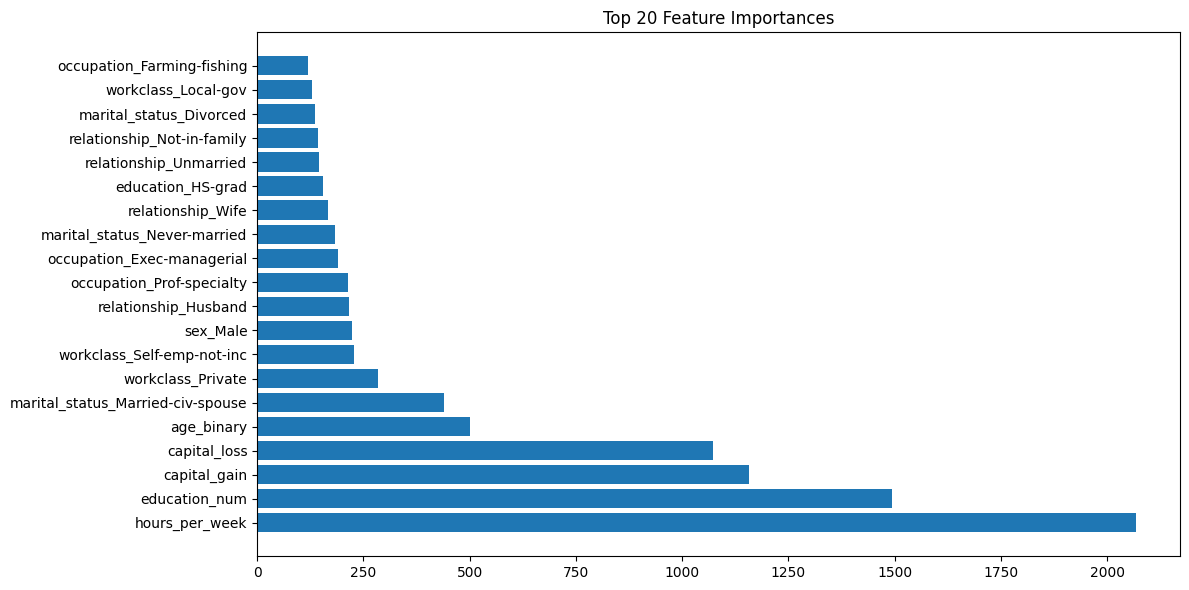


Evaluating fairness...
Disparate Impact before adversarial debiasing: 0.3125532926059101
Statistical Parity Difference before adversarial debiasing: -0.3177575306382874

Debiasing Model...

Creating Private Dataset

 Original dataset cross-tab
sex_Male    False  True 
age_binary              
0            8066  13779
1            6414  14209

 Private dataset cross-tab
sex_Male    False  True 
age_binary              
0            8455  13182
1            7371  13460

How much the values changed with the addition of privacy

Original age=1: 20623
Private age=1: 20831

Original sex=Female: 14480
Private sex=Female: 15826

Quantifying errors

Overall Absolute Error:
sex_Male    False  True 
age_binary              
0             389   -597
1             957   -749

Overall Relative Error Percentage:
sex_Male        False     True 
age_binary                     
0            4.822713 -4.332680
1           14.920486 -5.271307

Age-wise Relative Error Percentage:
age_binary
0   -0.952163


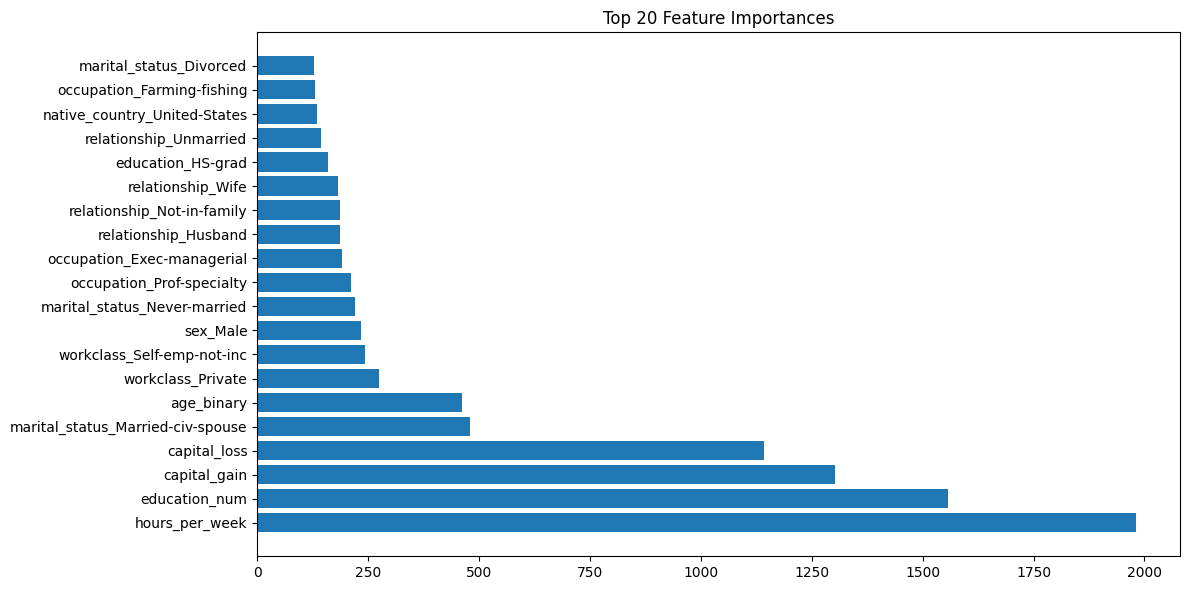

In [28]:
if __name__ == "__main__":
    main()